# 1. Import Dependencies and Data

In [1]:
#!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-12-10 18:12:13.356538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733865133.485712    6020 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733865133.520055    6020 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 18:12:13.723543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [3]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [6]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

I0000 00:00:1733865137.540552    6020 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4919 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


# 2. Viz Data and Build Dataset

In [7]:
# Do some data transformation
import numpy as np

In [8]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [9]:
# Getting data out of the pipeline
dataiterator.next()['image']

2024-12-10 18:12:17.676474: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

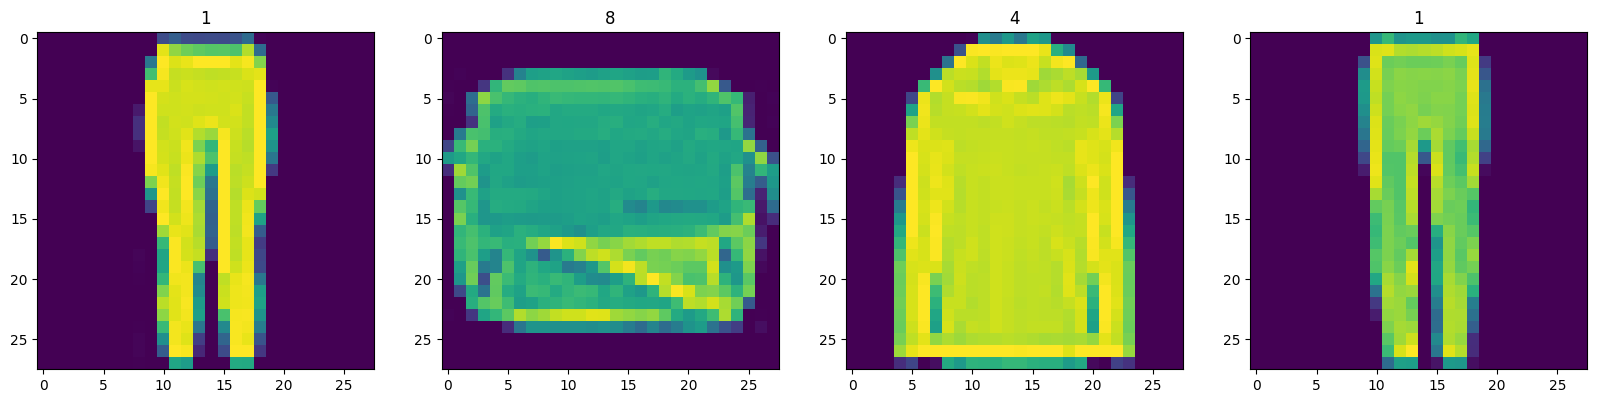

In [10]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [11]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [12]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [14]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [15]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Input(shape=(128,)))
    model.add(Dense(7*7*128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [16]:
generator = build_generator()

In [17]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [19]:
imgs = generator.predict(np.random.randn(4,128,1))
imgs.shape

I0000 00:00:1733865142.206497    6100 service.cc:148] XLA service 0x76ff70008520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733865142.206826    6100 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-12-10 18:12:22.244852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733865142.267092    6100 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-10 18:12:22.484105: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,14,14]{3,2,1,0}, f32[128,128,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_c

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1733865143.236180    6100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(4, 28, 28, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


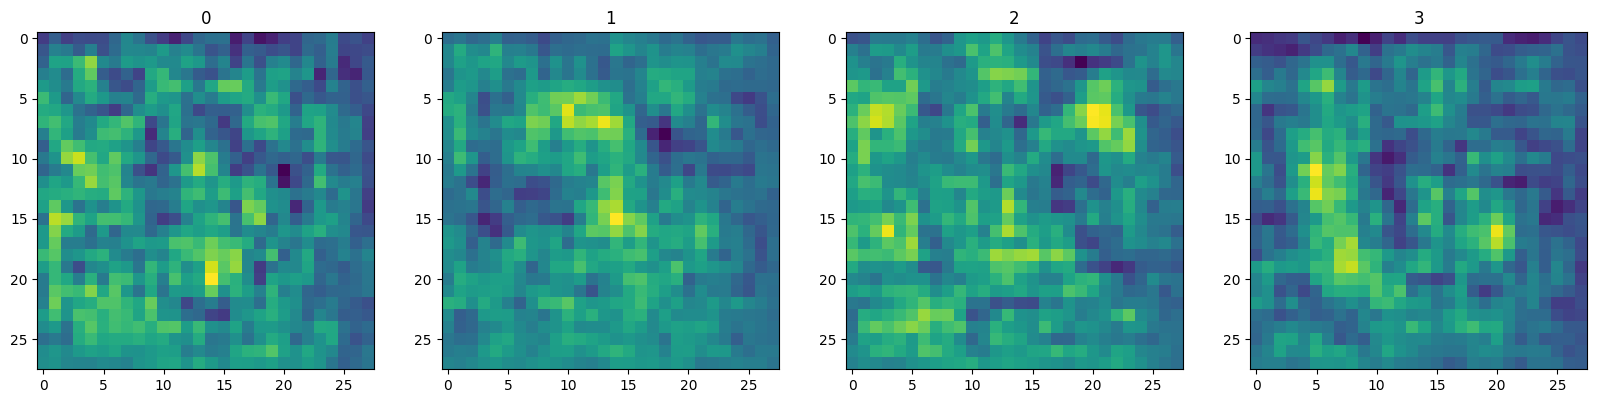

In [20]:
# Generate new fashion
imgs = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(imgs): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [21]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Input(shape=(28,28,1)))    
    model.add(Conv2D(32, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [22]:
discriminator = build_discriminator()

In [23]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
imgs.shape

(4, 28, 28, 1)

In [25]:
discriminator.predict(imgs)

2024-12-10 18:12:37.889054: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,64,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,24,24]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-10 18:12:37.964185: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,20,20]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_c

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


array([[0.49808735],
       [0.49805027],
       [0.49836054],
       [0.49796394]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [26]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [28]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [29]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [31]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [32]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [33]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [34]:
class GANCheckpoint(Callback):
    def __init__(self, save_freq=100, save_dir='checkpoints'):
        self.save_freq = save_freq  # Frecuencia en épocas para guardar
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)  # Crear el directorio si no existe

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:  # `epoch + 1` porque empieza desde 0
            gen_path = os.path.join(self.save_dir, f'generator_epoch_{epoch + 1}.weights.h5')
            disc_path = os.path.join(self.save_dir, f'discriminator_epoch_{epoch + 1}.weights.h5')
            
            # Guardar los pesos del generador y del discriminador
            self.model.generator.save_weights(gen_path)
            self.model.discriminator.save_weights(disc_path)
            
            print(f'\nCheckpoint guardado: \n- Generador: {gen_path} \n- Discriminador: {disc_path}')


### 4.3 Train 

In [35]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor(), GANCheckpoint(save_freq=100)])

Epoch 1/2000


2024-12-10 11:58:59.100447: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1/RandomUniform
2024-12-10 11:59:00.772766: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[128,64,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,24,24]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-10 11:59:00.993825: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potential

KeyboardInterrupt: 

### 4.4 Review Performance

In [35]:
# Cargar pesos entrenados (ruta a los archivos guardados)
fashgan.generator.load_weights('checkpoints/generator_epoch_1700.weights.h5')
fashgan.discriminator.load_weights('checkpoints/discriminator_epoch_1700.weights.h5')

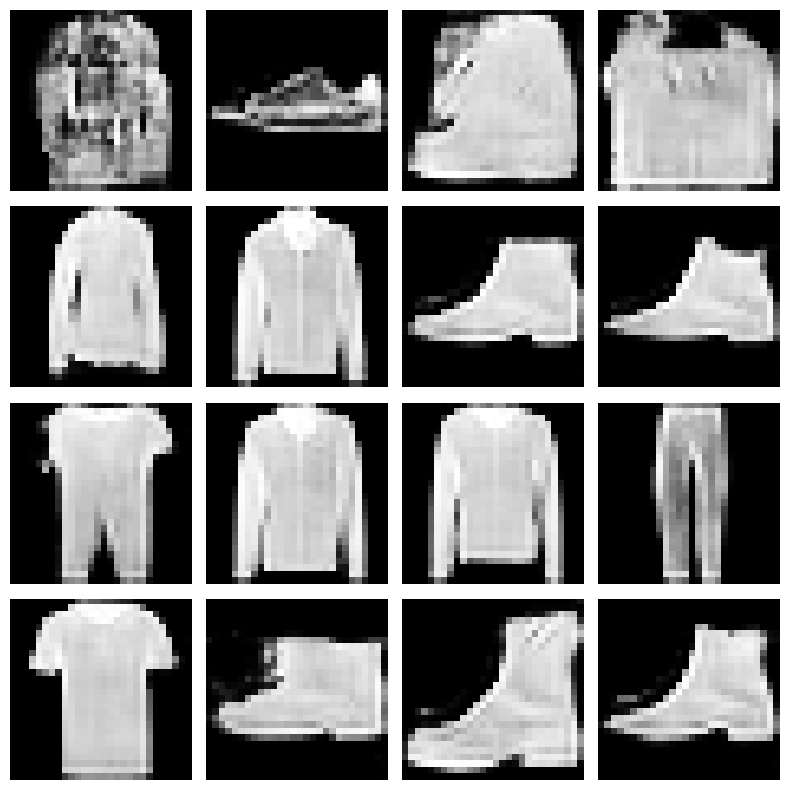

In [36]:
# Generar ruido aleatorio para 16 imágenes (batch size = 16)
noise = tf.random.normal((16, 128, 1))  # Batch size = 16, dimensiones = (128, 1)

# Generar imágenes con el generador
generated_images = fashgan.generator(noise, training=False)

# Escalar las imágenes al rango [0, 1] si están en [-1, 1]
generated_images = (generated_images + 1) / 2.0

# Configurar el tamaño de la figura
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Mostrar cada imagen en la cuadrícula 4x4
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, :, :, 0], cmap="gray")  # Extraer la imagen correspondiente
    ax.axis("off")  # Ocultar los ejes

# Ajustar el espaciado entre imágenes
plt.tight_layout()
plt.show()


### 5.1 Generate Images

Modelos cargados desde la época 100.
Modelos cargados desde la época 200.
Modelos cargados desde la época 300.
Modelos cargados desde la época 400.
Modelos cargados desde la época 500.
Modelos cargados desde la época 600.
Modelos cargados desde la época 700.
Modelos cargados desde la época 800.
Modelos cargados desde la época 900.
Modelos cargados desde la época 1000.
Modelos cargados desde la época 1100.
Modelos cargados desde la época 1200.
Modelos cargados desde la época 1300.
Modelos cargados desde la época 1400.
Modelos cargados desde la época 1500.
Modelos cargados desde la época 1600.
Modelos cargados desde la época 1700.
Modelos cargados desde la época 1800.
Modelos cargados desde la época 1900.
Modelos cargados desde la época 2000.


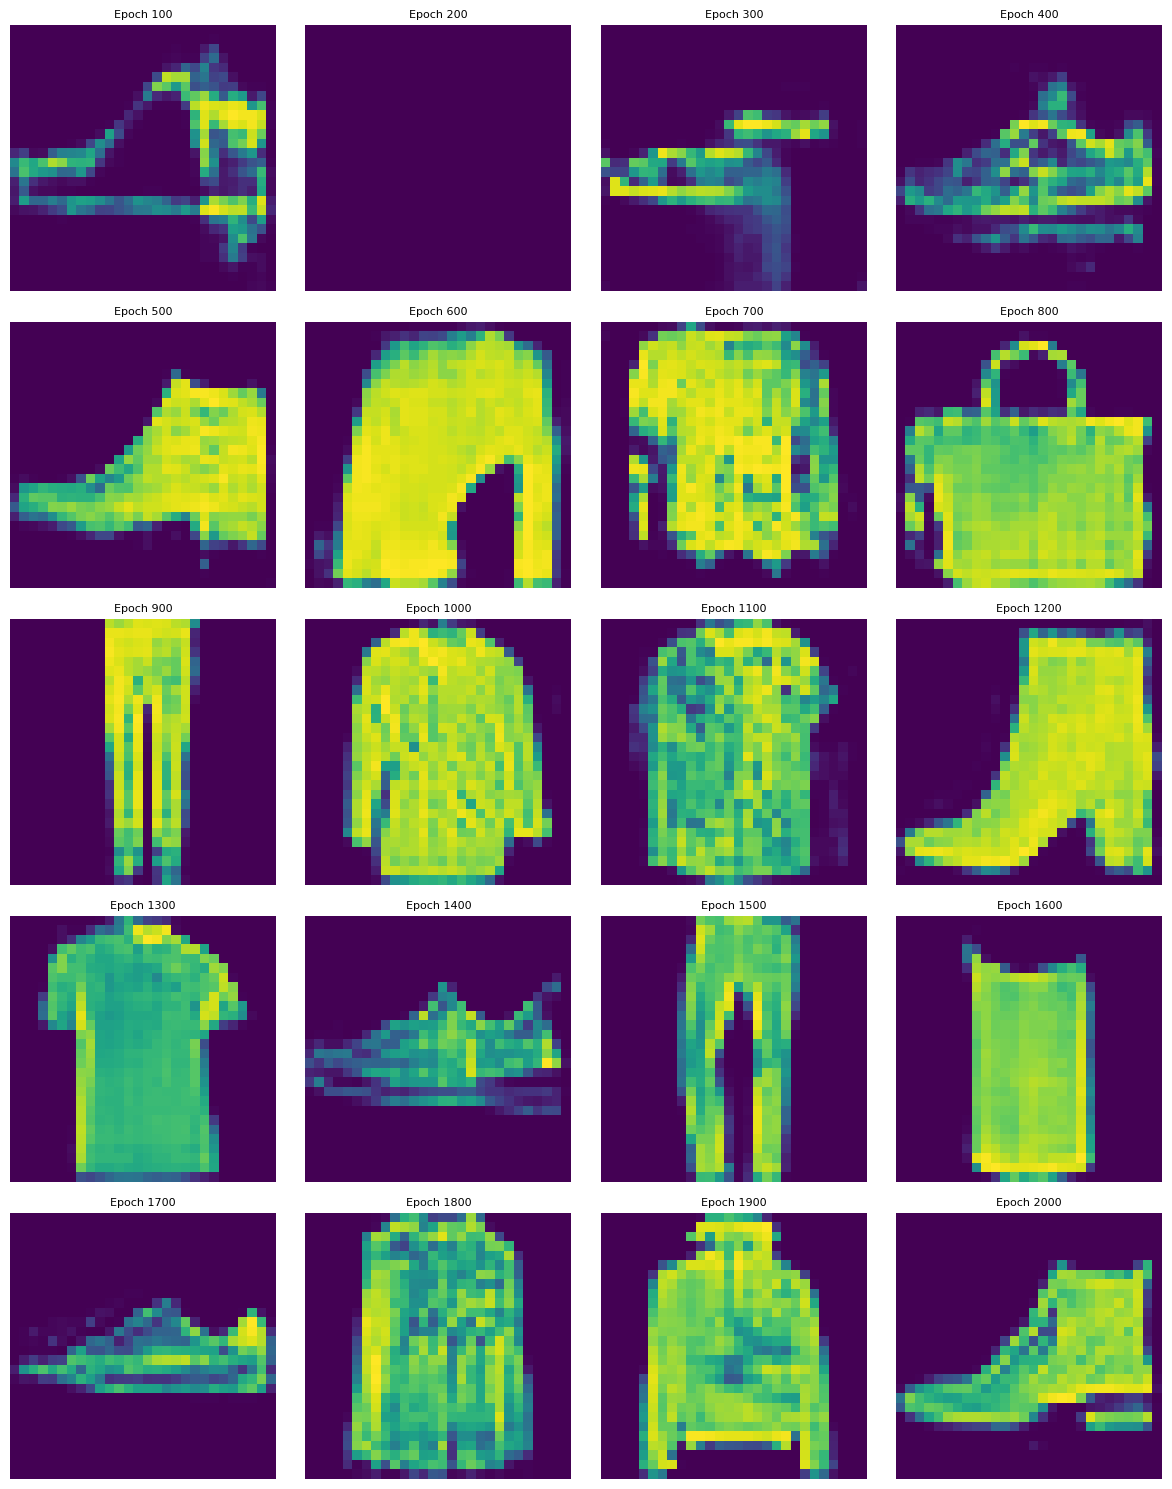

In [37]:
checkpoint_dir = 'checkpoints'
#random_latent_vector = tf.random.normal((1, 128, 1))  # Un vector de ruido para generar imágenes

def generate_images_from_checkpoints(generator, discriminator, checkpoint_dir, start_epoch=100, end_epoch=2000, step=100):
    images = []
    titles = []

    for epoch in range(start_epoch, end_epoch + 1, step):
        gen_path = os.path.join(checkpoint_dir, f'generator_epoch_{epoch}.weights.h5')
        disc_path = os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch}.weights.h5')
        
        if os.path.exists(gen_path) and os.path.exists(disc_path):
            generator.load_weights(gen_path)
            discriminator.load_weights(disc_path)
            print(f"Modelos cargados desde la época {epoch}.")
            
            # Generar un nuevo vector de ruido para cada checkpoint
            random_latent_vector = tf.random.normal((1, 128, 1))
            
            generated_image = generator(random_latent_vector, training=False)[0]
            generated_image = (generated_image * 127.5 + 127.5).numpy().astype("uint8")
            
            images.append(generated_image.squeeze())
            titles.append(f'Epoch {epoch}')
        else:
            print(f"Checkpoint faltante para la época {epoch}: {gen_path} o {disc_path}")

    num_images = len(images)
    num_cols = 4  
    num_rows = (num_images + num_cols - 1) // num_cols 
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))  # Ajustar tamaño
    axes = axes.flatten()
    
    for i in range(len(axes)):
        if i < num_images:
            axes[i].imshow(images[i])
            axes[i].set_title(titles[i], fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Llamar a la función con tu FashionGAN
generate_images_from_checkpoints(fashgan.generator, fashgan.discriminator, checkpoint_dir)

# 6 Resume training

In [39]:
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)
fashgan.generator.load_weights('checkpoints/generator_epoch_1700.weights.h5')
fashgan.discriminator.load_weights('checkpoints/discriminator_epoch_1700.weights.h5')

hist = fashgan.fit(ds ,initial_epoch=1700, epochs=2000, callbacks=[ModelMonitor(), GANCheckpoint(save_freq=100)])

Epoch 1701/2000


2024-12-10 12:00:28.319191: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : INTERNAL: ptxas exited with non-zero error code 2, output: ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_8', 8 bytes spill stores, 96 bytes spill loads
: If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.
2024-12-10 12:00:28.319390: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INTERNAL: ptxas exited with non-zero error code 2, output: ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_8', 8 bytes spill stores, 96 bytes spill loads
: If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.
	 [[{{node StatefulPartitionedCall}}]]


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/framework/errors_impl.py(462): __init__
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/context.py(1683): call_function
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py(320): fit
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipykernel_6064/3446796912.py(6): <module>
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/asyncio/events.py(80): _run
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/tornado/platform/asyncio.py(205): start
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel/kernelapp.py(739): start
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/site-packages/ipykernel_launcher.py(18): <module>
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/runpy.py(86): _run_code
  /home/lucas-carmusciano/miniconda3/envs/mi_entorno/lib/python3.10/runpy.py(196): _run_module_as_main


---
Comentarios:
* Se realizo el entrenamiento del modelo en unas 2000 epocas (hubo problemas de cortes de luz en el proceso, es por eso que se lo tuvo que continuar desde la epoca 1700 a 2000)
* Cada 100 epocas el modelo se guardo en la carpeta de checkpoints.